In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

# Zad 1
Wczytaj dane ze wszystkich plików do pojedynczej tablicy (używając Pandas)

In [2]:
folder_path = './data/names'

file_list = glob.glob(os.path.join(folder_path, '*.txt'))

print(len(file_list))

names_df_list = []

for file in file_list:
    data = pd.read_csv(file, delimiter=',', header=None)
    year = int(os.path.basename(file).split('.')[0][-4:])
    data = pd.concat([data, pd.Series([year] * len(data))], axis=1)
    names_df_list.append(data)

143


In [3]:
names_df = pd.concat(names_df_list, ignore_index=True)

column_names = ['Name', 'Sex', 'Quanity', 'Year']

names_df.columns = column_names

print(names_df)

             Name Sex  Quanity  Year
0        Jennifer   F    56323  1978
1         Melissa   F    28328  1978
2         Jessica   F    26103  1978
3             Amy   F    23212  1978
4         Heather   F    22270  1978
...           ...  ..      ...   ...
2085153      Zeph   M        5  2000
2085154     Zeven   M        5  2000
2085155     Ziggy   M        5  2000
2085156        Zo   M        5  2000
2085157     Zyier   M        5  2000

[2085158 rows x 4 columns]


# Zad 2
Określi ile różnych (unikalnych) imion zostało nadanych w tym czasie

# Zad 3
Określi ile różnych (unikalnych) imion zostało nadanych w tym czasie rozróżniając imiona męskie i żeńskie

In [4]:
num_uniq_names = len(names_df['Name'].unique())
num_uniq_names_female = len(names_df.loc[names_df['Sex'] == 'F']['Name'].unique())
num_uniq_names_male = len(names_df.loc[names_df['Sex'] == 'M']['Name'].unique())

print("Number of unique names across data:", num_uniq_names)
print("Number of unique Female names across data:", num_uniq_names_female)
print("Number of unique Male names across data:", num_uniq_names_male)

Number of unique names across data: 102449
Number of unique Female names across data: 70227
Number of unique Male names across data: 43655


# Zad 4
Stwórz nowe kolumny frequency_male i frequency_female i określ popularność każdego z imion w danym każdym roku dzieląc liczbę razy, kiedy imię zostało nadane przez całkowita liczbę urodzeń dla danej płci

In [5]:
names_df_pivot = names_df.pivot_table(index=['Year', 'Sex', 'Name'], values='Quanity')

names_male_freq = names_df_pivot.loc[(slice(None), 'M'), :].apply(lambda x: x.values/x.sum())
names_female_freq = names_df_pivot.loc[(slice(None), 'F'), :].apply(lambda x: x.values/x.sum())

names_df_pivot['frequency_male'] = names_male_freq
names_df_pivot['frequency_female'] = names_female_freq

names_df_pivot

Quanity  frequency_male  frequency_female
Year Sex Name                                              
1880 F   Abbie       71.0             NaN      3.929584e-07
         Abby         6.0             NaN      3.320775e-08
         Abigail     12.0             NaN      6.641550e-08
         Ada        652.0             NaN      3.608576e-06
         Adah        24.0             NaN      1.328310e-07
...                   ...             ...               ...
2022 M   Zyren        8.0    4.333331e-08               NaN
         Zyrie       11.0    5.958330e-08               NaN
         Zyrin        6.0    3.249998e-08               NaN
         Zyron       12.0    6.499997e-08               NaN
         Zyrus        8.0    4.333331e-08               NaN

[2085158 rows x 3 columns]

# Zad 5
Określ i wyświetl wykres złożony z dwóch podwykresów, gdzie osią x jest skala czasu, a oś y reprezentuje:
- liczbę urodzin w danym roku (wykres na górze)
- stosunek liczby narodzin dziewczynek do liczby narodzin chłopców w każdym roku(wykres na dole) W którym roku zanotowano najmniejszą, a w którym największą różnicę w liczbie urodzeń między chłopcami a dziewczynkami (pytanie dotyczy podwykresu przedstawiającego stosunek liczby urodzin)? Odpowiedź wyznacz i wyświetl na ekranie

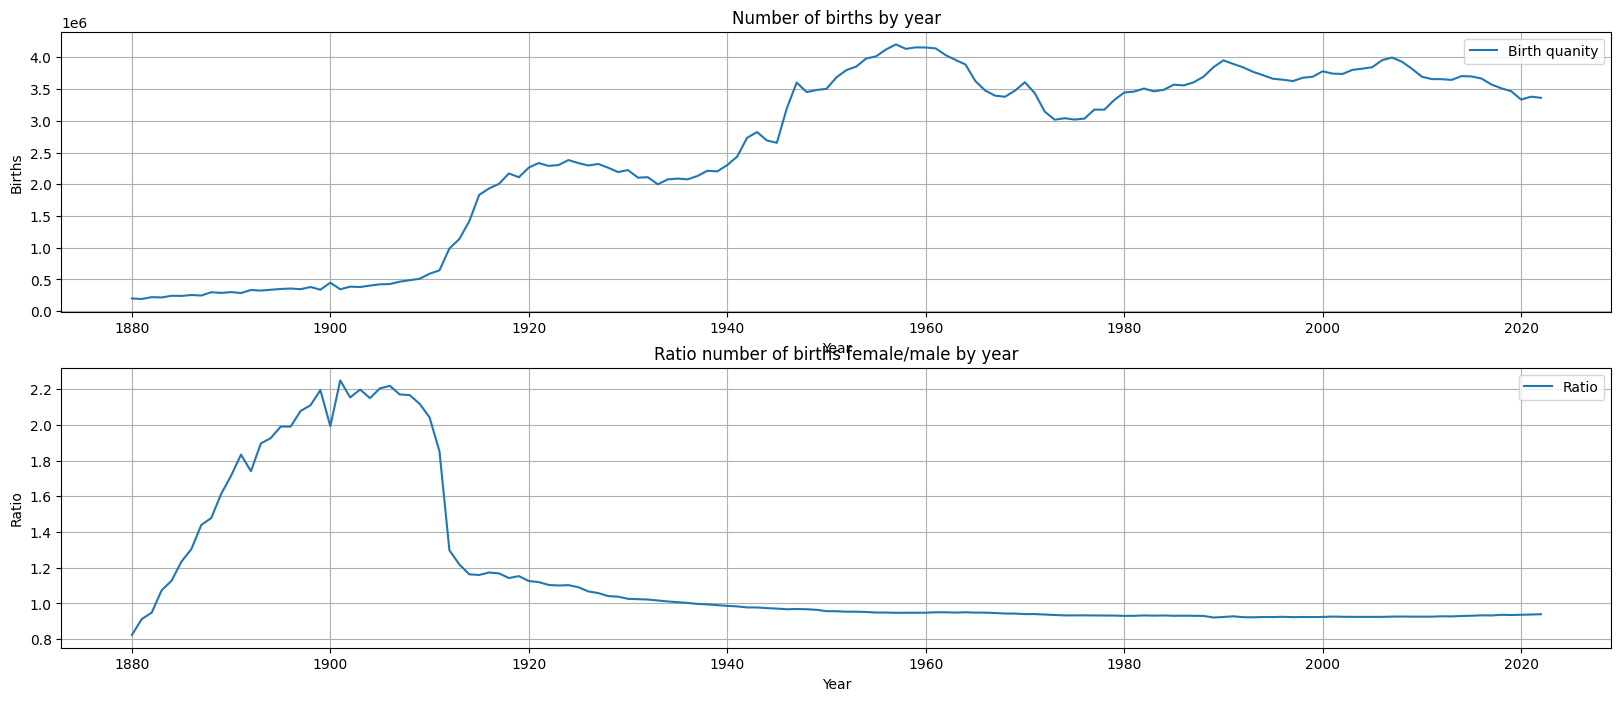

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))


years = names_df_pivot.index.get_level_values('Year').unique()
sum_by_year = names_df.groupby(['Year'])['Quanity'].sum()

ax[0].plot(years, sum_by_year.values, label='Birth quanity')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Births')
ax[0].set_title('Number of births by year')
ax[0].legend(loc='best')
ax[0].grid(True)

sum_by_year_female = names_df.groupby(['Year', 'Sex'])['Quanity'].sum().loc[(slice(None), 'F')]
sum_by_year_male = names_df.groupby(['Year', 'Sex'])['Quanity'].sum().loc[(slice(None), 'M')]
ratio = sum_by_year_female.values/sum_by_year_male.values

ax[1].plot(years, ratio, label='Ratio')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Ratio')
ax[1].set_title('Ratio number of births female/male by year')
ax[1].legend(loc='best')
ax[1].grid(True)

# Zad 6
Wyznacz 1000 najpopularniejszych imion dla każdej płci w całym zakresie czasowym, metoda powinna polegać na wyznaczeniu 1000 najpopularniejszych imion dla każdego roku i dla każdej płci osobno. Jako najpopularniejsze należy uznać imiona, które najdłużej zajmowały wysokie miejsce na liście rankingowej, żeby uniknąć wpływu liczby urodzin w danym roku na wynik (liczba urodzin spada stąd, nieprawidłowo przeprowadzona procedura może powodować że imiona nadawane w wyżu i stosowane w tym czasie zdominują ranking) proszę ranking Top1000 określić jako sumę ważoną względnej popularności danego imienia w danym roku (patrz pkt 4)

In [113]:
top_names_df = names_df_pivot.copy().reset_index()

top_names_group_filtered = top_names_df.groupby(['Year', 'Sex']).apply(lambda x: x.nlargest(1000, 'frequency_male' if x['Sex'].iloc[0] == 'M' else 'frequency_female')).reset_index(drop=True)

# top_names_group_filtered = top_names_group_filtered.pivot_table(index=['Year', 'Sex'], values=['Quanity', 'frequency_male', 'frequency_female'])

# quanity_female = top_names_group_filtered.loc[(slice(None), slice(None)), :]['Quanity'].values
# quanity_male = top_names_group_filtered.loc[(slice(None), 'M'), :]['Quanity'].values

# top_names_group_filtered['weighted_sum_female'] = top_names_group_filtered.loc[(slice(None), slice(None)), :]['frequency_female'].values * quanity_female
# top_names_group_filtered['weighted_sum_male'] = top_names_group_filtered.loc[(slice(None), slice(None)), :]['frequency_male'].values * quanity_female

top_names_group_filtered['weighted_sum_female'] = top_names_group_filtered['frequency_female'] * top_names_group_filtered['Quanity']
top_names_group_filtered['weighted_sum_male'] = top_names_group_filtered['frequency_male'] * top_names_group_filtered['Quanity']

top_names_male = top_names_group_filtered.nlargest(1000, 'weighted_sum_male')
top_names_female = top_names_group_filtered.nlargest(1000, 'weighted_sum_female')

# print(top_names_female)
name_counts_male = top_names_male['Name'].value_counts()
name_counts_male

name_counts_female = top_names_female['Name'].value_counts()
name_counts_female


Name
Mary        63
Patricia    36
Barbara     34
Jennifer    27
Betty       27
            ..
Tracy        1
Tiffany      1
Kelly        1
Cindy        1
Ava          1
Name: count, Length: 74, dtype: int64

# Zad 7
Wyświetl na jednym wykresie zmiany dla imienia męskiego John i pierwszego imienia żeńskiego rankingu top-1000 (zaopatrz wykres w odpowiednią legendę):
- na osi Y po lewej liczbę razy kiedy imę zostało nadane w każdym roku (wyświetl ile razy nadano to imię w 1934, 1980 i 2022r)?
- na osi Y po prawej popularność tych imion w każdym z tych lat

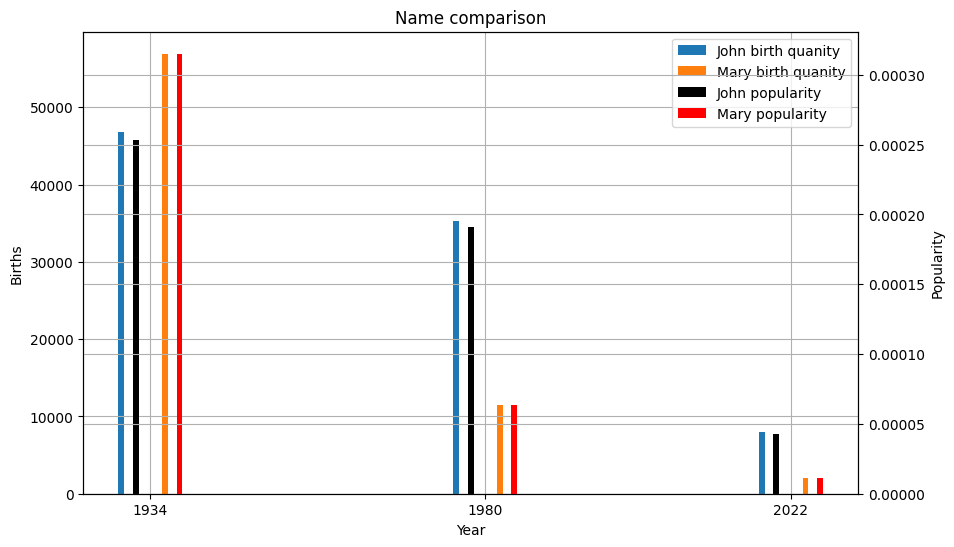

In [161]:
fig, ax = plt.subplots(figsize=(10, 6))

John_data = names_df_pivot.loc[([1934, 1980, 2022], 'M', 'John'), :]
top_female = name_counts_female.index[0]
top_female_data = names_df_pivot.loc[([1934, 1980, 2022], 'F', top_female), :]
years = John_data.index.get_level_values('Year')

width = 2

bar1 = ax.bar(years-2*width, John_data['Quanity'], label='John birth quanity')
bar2 = ax.bar(years+width, top_female_data['Quanity'], label=f'{top_female} birth quanity')
ax.set_xlabel('Year')
ax.set_ylabel('Births')
ax.set_title('Name comparison')
ax.grid(True)
ax.set_xticks(years)
ax.set_xticklabels(years)

ax2 = ax.twinx()
bar3 = ax2.bar(years-width, John_data['frequency_male'], label='John popularity', color='black')
bar4 = ax2.bar(years+2*width, top_female_data['frequency_female'], label=f'{top_female} popularity', color='red')
ax2.set_ylabel('Popularity')
ax2.grid(True)

# Combine the legends
bars = [bar1, bar2, bar3, bar4]
labels = [bar.get_label() for bar in bars]
ax.legend(bars, labels, loc='best')

plt.show()
